# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, Concatenate
from keras.optimizers import Adam
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud



# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# get data

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/AsukaaNao/datasets/refs/heads/main/cyberbullying_tweets.csv"
data = pd.read_csv(url)

# Makesure all of the attribuites are in string format
data['tweet_text'] = data['tweet_text'].astype(str)
data['cyberbullying_type'] = data['cyberbullying_type'].astype(str)
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


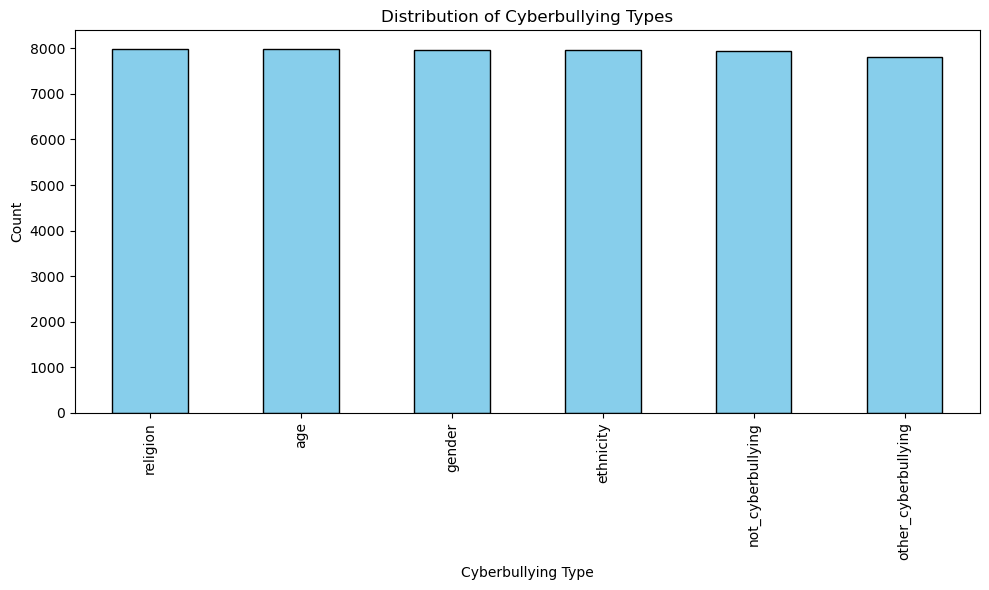

In [3]:
import matplotlib.pyplot as plt

# Plotting the distribution of 'cyberbullying_type'
plt.figure(figsize=(10,6))
data['cyberbullying_type'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Cyberbullying Type')
plt.ylabel('Count')
plt.title('Distribution of Cyberbullying Types')

# Show the plot
plt.tight_layout()
plt.show()


### The distribution of the dataset is pretty balanced, no need balancing.

# preprocessing

In [4]:
# Define stopwords and common slang dictionary
stop_words = set(stopwords.words('english'))
# Customize stopwords (some how theese word are abundant in the dataset)
stop_words.add('rt')  # Add 'rt'
stop_words.add('u')   # Add 'u'

# Mapping for internet slang/abbreviations
slang_dict = {
    "idk": "i don't know",
    "wtd": "what to do",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "brb": "be right back",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the fuck",
    "omw": "on my way",
    "fyi": "for your information",
    "imo": "in my opinion",
    "ikr": "i know, right",
    "nvm": "never mind",
    "ftw": "for the win",
    "thx": "thanks",
    "np": "no problem",
    "gtg": "got to go",
    "afk": "away from keyboard",
    "bff": "best friends forever",
    "wyd": "what are you doing",
    "hbu": "how about you",
    "ily": "i love you",
    "omfg": "oh my fucking god",
    "gg": "good game",
    "gr8": "great",
    "yolo": "you only live once",
    "tmi": "too much information",
    "stfu": "shut the fuck up",
    "btfo": "back the fuck off",
    "wtg": "way to go",
    "srsly": "seriously",
    "jk": "just kidding",
    "hbd": "happy birthday",
    "asap": "as soon as possible",
    "fml": "fuck my life",
    "ty": "thank you",
    "np": "no problem",
    "ikr": "i know, right",
    "idc": "i don't care",
    "ttfn": "ta ta for now",
    "dw": "don't worry",
    "rn": "right now",
    "rt" : "retweet",
}
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# Function to clean and preprocess tweets
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags but keep the text (e.g., #happy -> happy)
    tweet = re.sub(r'#', '', tweet)
    # Convert tweet to lowercase
    tweet = tweet.lower()
    # Replace slang with their mapped meaning
    words = tweet.split()
    words = [slang_dict.get(word.lower(), word) for word in words]
    tweet = ' '.join(words)
    
    # Tokenize and remove stopwords while preserving sentence context
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    
    # Rejoin tokens to form the cleaned sentence
    cleaned_tweet = ' '.join(tokens)
    return cleaned_tweet
    # Sentiment analysis to detect bullying context
    sentiment = sia.polarity_scores(tweet)  # Get sentiment scores
    
    # If sentiment is negative, it's more likely to be bullying
    if sentiment['compound'] <= -0.3:  # You can adjust the threshold as needed
        # Add a flag indicating potential bullying
        cleaned_tweet += " [bullying]"
    
    return cleaned_tweet


# Apply preprocessing
data['tweet_text'] = data['tweet_text'].apply(preprocess_tweet)

# Display sample results
print(data[['tweet_text']].head())

encoding_map = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

# Apply the mapping to the 'cyberbullying_type' column
data['cyberbullying_type'] = data['cyberbullying_type'].map(encoding_map)

                                          tweet_text
0        words katandandre , food crapilicious ! mkr
1  aussietv white ? mkr theblock imacelebrityau t...
2               classy whore ? red velvet cupcakes ?
3  meh . : p thanks heads , concerned another ang...
4  isis account pretending kurdish account . like...


In [5]:
#see the procesed tweets
data.head()

,tweet_text,cyberbullying_type
0,"words katandandre , food crapilicious ! mkr",0
1,aussietv white ? mkr theblock imacelebrityau t...,0
2,classy whore ? red velvet cupcakes ?,0
3,"meh . : p thanks heads , concerned another ang...",0
4,isis account pretending kurdish account . like...,0


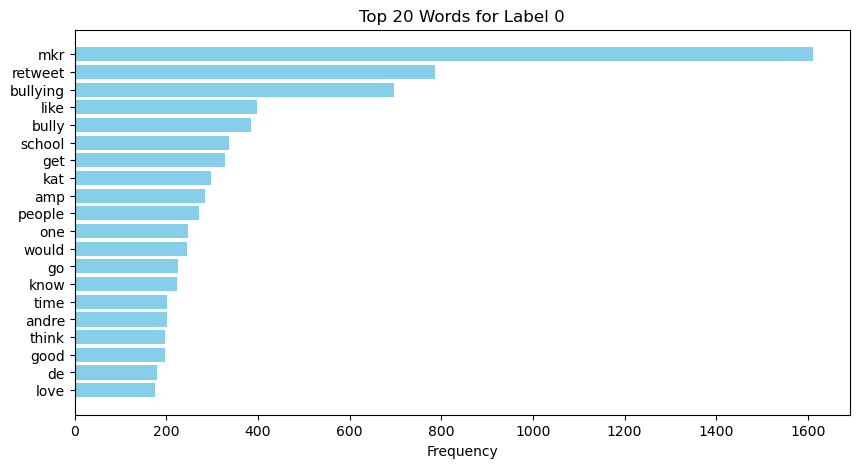

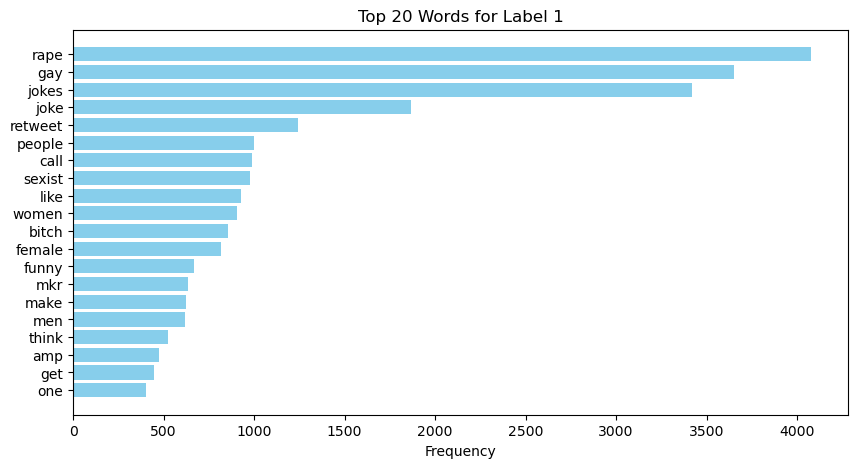

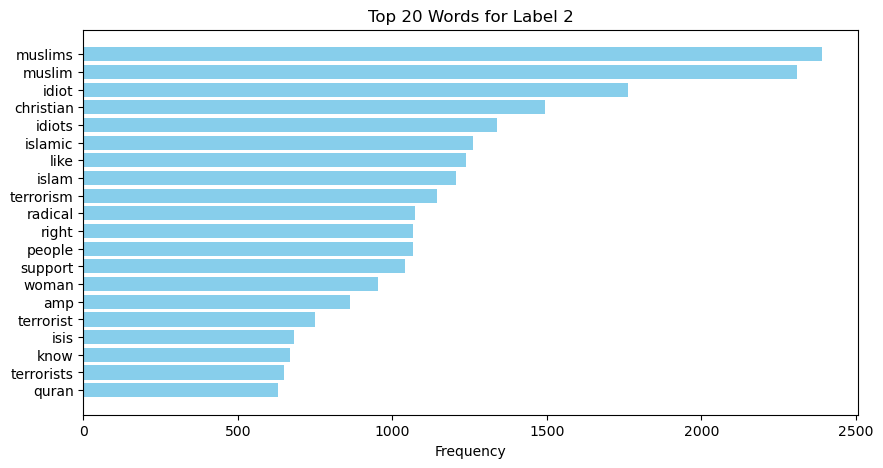

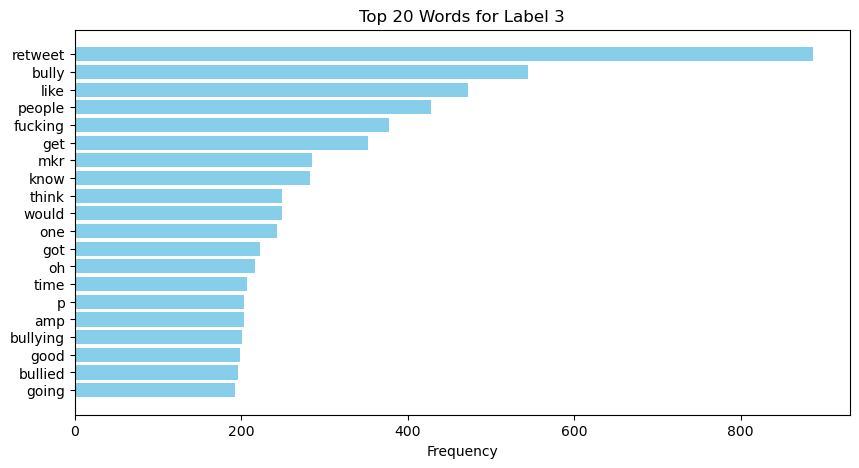

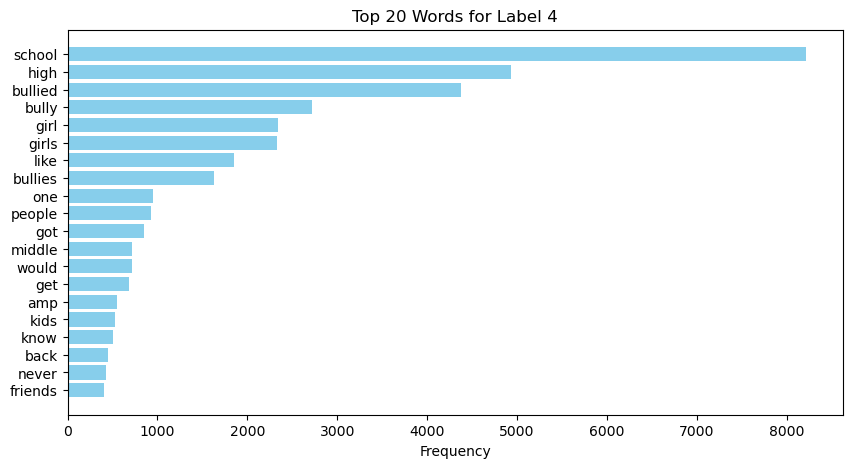

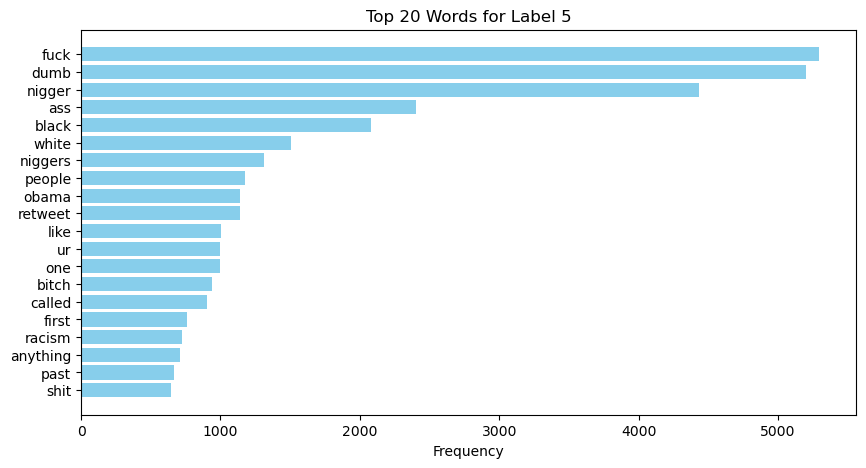

In [6]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to preprocess and tokenize tweets
def get_word_frequency(tweets):
    all_words = []
    for tweet in tweets:
        tokens = word_tokenize(tweet)
        filtered_tokens = [word.lower() for word in tokens if word.isalpha()]
        all_words.extend(filtered_tokens)
    return Counter(all_words)

# Initialize a dictionary to store word frequencies for each label
label_word_freq = {}

# Loop through each unique label in 'cyberbullying_type' and calculate word frequencies
for label in data['cyberbullying_type'].unique():
    label_tweets = data[data['cyberbullying_type'] == label]['tweet_text']
    label_word_freq[label] = get_word_frequency(label_tweets)

# Convert word frequency counters to DataFrames and sort them
label_word_freq_df = {}
for label, word_freq in label_word_freq.items():
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    label_word_freq_df[label] = word_freq_df

import matplotlib.pyplot as plt

# Display the top 20 words for each label as a separate bar chart
for label, word_freq_df in label_word_freq_df.items():
    # Select the top 20 words
    top_20_words = word_freq_df.head(20)
    
    # Create a bar chart
    plt.figure(figsize=(10, 5))
    plt.barh(top_20_words['Word'], top_20_words['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 20 Words for Label {label}')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest frequency at the top
    plt.show()


In [7]:
data.head()

,tweet_text,cyberbullying_type
0,"words katandandre , food crapilicious ! mkr",0
1,aussietv white ? mkr theblock imacelebrityau t...,0
2,classy whore ? red velvet cupcakes ?,0
3,"meh . : p thanks heads , concerned another ang...",0
4,isis account pretending kurdish account . like...,0


# modeling

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tokenize the cleaned tweets
tokenizer = Tokenizer(num_words=5000)  # Limit to the top 5000 most frequent words
tokenizer.fit_on_texts(data['tweet_text'])

# Convert tweets to sequences of integers
X = tokenizer.texts_to_sequences(data['tweet_text'])

# Pad sequences to ensure they have the same length
max_length = 100  # You can adjust this based on the average tweet length
X = pad_sequences(X, padding='post', maxlen=max_length)

# Define the target variable (encoded labels)
y = data['cyberbullying_type']

# Apply one-hot encoding for multi-class classification
y = to_categorical(y, num_classes=len(encoding_map))  # Convert labels to one-hot encoded format

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

labels = data['cyberbullying_type']

# Class weights for imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels.values
)
class_weights_dict = dict(zip(np.unique(labels), class_weights))

print(class_weights_dict)

# Calculate class weights to handle imbalanced classes
class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}  # because the class weight is simmilar, so all get 1 as the weight

# Build the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(encoding_map), activation='softmax')  # Use softmax for multi-class classification
])#we use sequential model

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback (early stopping if the vall los keep increasing, to prevent overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=11,
    batch_size=32,
    validation_data=(X_test, y_test),
    # class_weight=class_weights,
    # uncomment if wanna do early stopping
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {accuracy*100:.2f}%")

# Predict cyberbullying labels for the test set
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)  # Convert one-hot predictions to class labels

# Convert one-hot encoded labels back to class labels for the test set
y_test_labels = y_test.argmax(axis=1)

# Classification report
print(classification_report(y_test_labels, y_pred))




{0: 1.0004615061883784, 1: 0.9969480329445211, 2: 0.9938317912811536, 3: 1.0160637436618518, 4: 0.994577911244578, 5: 0.9984507808901729}
Epoch 1/11


c:\Users\bryan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1342/1342 - 119s - 89ms/step - accuracy: 0.7500 - loss: 0.5944 - val_accuracy: 0.8281 - val_loss: 0.4332
Epoch 2/11
1342/1342 - 120s - 89ms/step - accuracy: 0.8352 - loss: 0.4072 - val_accuracy: 0.8356 - val_loss: 0.4341
Epoch 3/11
1342/1342 - 117s - 87ms/step - accuracy: 0.8593 - loss: 0.3532 - val_accuracy: 0.8333 - val_loss: 0.4583
Epoch 4/11
1342/1342 - 124s - 93ms/step - accuracy: 0.8714 - loss: 0.3209 - val_accuracy: 0.8325 - val_loss: 0.4673
150/150 - 2s - 16ms/step - accuracy: 0.8281 - loss: 0.4332
Test accuracy: 82.81%
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
              precision    recall  f1-score   support

           0       0.70      0.39      0.50       787
           1       0.89      0.83      0.86       798
           2       0.97      0.94      0.96       784
           3       0.55      0.85      0.67       798
           4       0.97      0.98      0.97       806
           5       0.99      0.97      0.98       797

    accuracy                           0.83 

# Evaluation

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print(classification_report(y_test_labels, y_pred))

# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(encoding_map.keys()), yticklabels=list(encoding_map.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


              precision    recall  f1-score   support

           0       0.70      0.39      0.50       787
           1       0.89      0.83      0.86       798
           2       0.97      0.94      0.96       784
           3       0.55      0.85      0.67       798
           4       0.97      0.98      0.97       806
           5       0.99      0.97      0.98       797

    accuracy                           0.83      4770
   macro avg       0.84      0.83      0.82      4770
weighted avg       0.84      0.83      0.82      4770



NameError: name 'conf_matrix' is not defined

<Figure size 1000x700 with 0 Axes>

### The accuracy is more than 0.75 as stated in our proposal, but alittle bit of confusion in other_bullying and non_bullying (the dataset is simmilar)

# Testing

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

#preprocess the raw input first
def predict_text_array(text_array, tokenizer, model, max_length, preprocess_function, encoding_map):
    # Preprocess the input array of text
    cleaned_texts = [preprocess_function(text) for text in text_array]

    # Convert the cleaned texts to sequences
    text_sequences = tokenizer.texts_to_sequences(cleaned_texts)

    # Pad the sequences to ensure they are of uniform length
    padded_sequences = pad_sequences(text_sequences, padding='post', maxlen=max_length)

    # Prepare sentiment input using SentimentIntensityAnalyzer
    sentiment_input = np.array([analyze_sentiment(text) for text in text_array]).reshape(-1, 1)

    # Predict the cyberbullying type for each input text
    predictions = model.predict([padded_sequences, sentiment_input])  # Pass both inputs

    predicted_class_indices = predictions.argmax(axis=1)  # Get the predicted class indices

    # Map the predicted indices back to class labels
    index_to_label = {v: k for k, v in encoding_map.items()}
    predicted_labels = [index_to_label[idx] for idx in predicted_class_indices]

    return predicted_labels

# Define max_length based on your model's input sequence length (typically set during training)
max_length = X_text.shape[1]  # Use the sequence length from training data

# Example text array for prediction
text_array = [
    "You are so annoying and stupid.",
    "You are not annoying and not stupid.",
    "This is a wonderful and positive day!",
    "I think you are being harassed online.",
    "Neutral and boring sentence.",
    "Offensive and abusive words are here.",
    "i'm muslim and i'm proud and i like it",
    "he is not retard",
    "he is retard",
    "she is not a good person",
    "she is a good person",
    "fucking moslems terrorists",
    "i'm islam",
    "usually girls are bad, but they are actually good at everything you know",
    "I love hummans, there great!"
]

# Predict the labels for the input text array
predicted_labels = predict_text_array(
    text_array=text_array,
    tokenizer=tokenizer,
    model=model,
    max_length=max_length,
    preprocess_function=preprocess_tweet,
    encoding_map=encoding_map
)

# Print results
for text, label in zip(text_array, predicted_labels):
    print(f"Text: '{text}' -> Predicted Label: {label}")

NameError: name 'X_text' is not defined